In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
tf.__version__

'1.15.0'

In [3]:

datadir = 'Data/phago_only/'

In [4]:
import glob

def read_mm(mfile):
    hm=np.memmap(mfile, dtype=np.int32, shape=(4,))
    shape = tuple(hm)
    del hm

    mm = np.memmap(mfile, dtype=np.float32, shape=shape)
    mm.shape
    #del mm
    amm = mm[:,:,:,[2, 0, 4, 0, 1]]
    amm = amm[:,:,:, [0,2,4]]
    del mm
    return amm

def read_data(globpattern):
    ifiles = glob.glob(globpattern) #'Data/AAI/tiffs_FSS_24h*.mm')
    ammdict = dict()
    for i in ifiles:
        amm = read_mm(i)
        amm_m = amm.mean(axis=(1,2), keepdims=True)
        amm_std = amm.std(axis=(1,2), keepdims=True)
        amm = (amm - amm_m)/amm_std
        print(amm.shape)
        ammdict[i.split('/')[-1]] = amm
   
    return ammdict

ammdict = read_data('Data/phago_only/*.mm')

(72, 64, 64, 3)
(84, 64, 64, 3)
(170, 64, 64, 3)
(142, 64, 64, 3)
(141, 64, 64, 3)


In [5]:
tf.reset_default_graph()
#dud = tf.get_variable('v1', shape=[2])
sess = tf.Session()


dict_keys(['phago_only_PhagoOnly_R3.mm', 'phago_only_PhagoOnly_R2.mm', 'phago_only_PhagoOnly_R5.mm', 'phago_only_PhagoOnly_R4.mm', 'phago_only_PhagoOnly_R1.mm'])


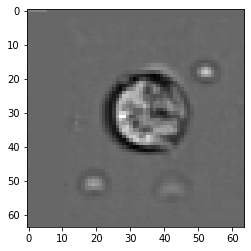

In [6]:
print(ammdict.keys())
plt.imshow(ammdict['phago_only_PhagoOnly_R1.mm'][4,:,:,0], cmap='gray')

In [7]:
cpdir = 'Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/'
checkpoint = 'best-checkpoint-21300'
if not cpdir.endswith('/'):
    cpdir += '/'

cpmeta = cpdir + checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, cpdir + checkpoint)

W0825 10:53:17.384809 140492512778048 meta_graph.py:887] The saved meta_graph is possibly from an older release:
'metric_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


In [8]:
pq = 'dense_1/BiasAdd'.lower()
print(pq)
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    if pq in op.name.lower():
        print(op.name, op.outputs)

dense_1/biasadd
dense_1/BiasAdd [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/BiasAddGrad [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(128,) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/group_deps []
gradients/dense_1/BiasAdd_grad/tuple/control_dependency [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1 [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(128,) dtype=float32>]


In [9]:
a = sess.graph.get_tensor_by_name('dense_1/BiasAdd:0')
b = sess.graph.get_tensor_by_name('LeakyRelu_13:0') #'dense_1/BiasAdd:0')
sm = sess.graph.get_tensor_by_name('Softmax:0')

softmax = sess.graph.get_tensor_by_name('Softmax:0')
batch = sess.graph.get_tensor_by_name('Placeholder:0')

In [10]:
a, b, sm

(<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'LeakyRelu_13:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [11]:
#data.max(axis=(0,1,2)), data.min(axis=(0,1,2))

In [12]:
for k, v in ammdict.items():
    #print(k, v.shape)
    amm = ammdict[k]
    mask = np.any(np.isnan(amm), axis=(1,2,3))
    amm = amm[~mask]
    ammdict[k] = amm

array([], shape=(0, 64, 64, 3), dtype=float32)

In [14]:
ammdict[list(ammdict.keys())[2]].shape

(170, 64, 64, 3)

In [20]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
adflist = list()
d2list = list()
for k, v in ammdict.items():
    d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:v[:, 16:48, 16:48, :]})
    d2list.append(d2)
    p2x = np.argmax(p2, axis=-1)
    s = k.split('_')
    dataset = k #"{} {} {}".format(s[1], s[2], s[3][0])
    xdf = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1), 'dataset':dataset})
    adflist.append(xdf)

adf = pd.concat(adflist, axis=0)
d2array = np.concatenate(d2list)
d2array.shape

(609, 128)

In [21]:
adf.head()


,sm,smmax,dataset
0,0,0.988925,phago_only_PhagoOnly_R3.mm
1,4,0.547325,phago_only_PhagoOnly_R3.mm
2,4,0.542458,phago_only_PhagoOnly_R3.mm
3,0,0.994146,phago_only_PhagoOnly_R3.mm
4,0,0.658032,phago_only_PhagoOnly_R3.mm


In [22]:
np.histogram(adf['sm'], bins=[0,.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

(array([292,   1,   1,  11, 192,  77,  35]),
 array([0. , 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]))

In [28]:
radf = adf.reset_index()

In [29]:
radf.to_pickle("phago_only_radf_pickle_2020.pkl")

In [69]:
rdir = "/n/core/cyto/_Data/Rohner/ROP/Imagestream Assay Data/Deep Learning_Feature_Analysis/Snail/Data for Classifier Analysis/phago only"
dirs = os.listdir(rdir)

glist = list()
for d in dirs:
    dd = rdir + '/' + d
    files = glob.glob(dd + '/*Ch1.*.tif')
    files = sorted(files, key=lambda x: int(os.path.basename(x).split("_")[2]))
    fdict = dict()
    #print(files[0:5])
    
    for index, f in enumerate(files):
        bf = os.path.basename(f)
        _sp = bf.split("_")
        cid = int(_sp[2])
        channel = int(_sp[3][2:].split(".")[0])
        glist.append({'index':index, 'cell_id':cid, 'directory':d, 'channel':channel})

gdf = pd.DataFrame(glist)

gdf.head()

    


,index,cell_id,directory,channel
0,0,158,PhagoOnly_R4,1
1,1,413,PhagoOnly_R4,1
2,2,503,PhagoOnly_R4,1
3,3,553,PhagoOnly_R4,1
4,4,606,PhagoOnly_R4,1


In [75]:
def mapdataset(x):
    #phago_only_PhagoOnly_R3.mm
    return "_".join(x.split("_")[2:])[:-3]

radf['directory'] = radf['dataset'].map(mapdataset)

In [78]:
merge_df = radf.merge(gdf, on=["index", "directory"])

In [81]:
merge_df[merge_df.directory == 'PhagoOnly_R2']

,index,sm,smmax,dataset,directory,cell_id,channel
72,0,0,0.402429,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,146,1
73,1,4,0.897734,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,320,1
74,2,0,0.377605,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,652,1
75,3,0,0.999063,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,724,1
76,4,0,0.904339,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,804,1
...,...,...,...,...,...,...,...
151,79,0,0.835413,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9237,1
152,80,0,0.999468,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9266,1
153,81,0,0.999452,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9586,1
154,82,0,0.999712,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9692,1


In [82]:
merge_df.to_csv("snail_phago_classes.csv")

In [83]:
%pwd

'/home/cjw/Code/DeepLearning/classifier'